In [117]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, silhouette_score
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans

import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from PIL import Image

import requests
from PIL import Image
import numpy as np
from io import BytesIO
import os



In [250]:
bp_track = pd.read_csv('data/bp_track.csv')

C:\Users\Shank\AppData\Local\Temp\ipykernel_20448\1573399701.py:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  bp_track = pd.read_csv('data/bp_track.csv')


In [251]:
bp_genre = pd.read_csv('data/bp_genre.csv')

In [252]:
bp_genre.head()

,genre_id,genre_name,song_count,genre_url,updated_on
0,8,Hard Dance / Hardcore,178646,/genre/hard-dance-hardcore/8,2023-09-19 15:01:03
1,50,Nu Disco / Disco,157934,/genre/nu-disco-disco/50,2023-09-19 15:01:03
2,12,Deep House,897280,/genre/deep-house/12,2023-09-19 15:01:03
3,85,Bass / Club,20716,/genre/bass-club/85,2023-09-19 15:01:03
4,94,Electro (Classic / Detroit / Modern),19615,/genre/electro-classic-detroit-modern/94,2023-09-19 15:01:03


In [253]:
bp_track.drop(columns=['track_id', 'title', 'mix', 'is_remixed', 'release_date', 'track_url', 'duration', 'duration_ms', 'isrc', 'updated_on', 'is_matched_spot', 'subgenre_id', 'label_id', 'release_id'], inplace=True, axis=1)

In [254]:
bp_track.isnull().sum()

genre_id       0
bpm            0
key_id      6254
dtype: int64

In [255]:
bp_track = bp_track.dropna()

In [256]:
bp_key = pd.read_csv('data/bp_key.csv')

In [257]:
bp_track_updated = pd.merge(bp_track, bp_key[['key_id', 'scale_numeric_value']], on='key_id', how='left')

# Drop the old 'key_id' and rename 'scale_numeric_value' to 'key_id'
bp_track = bp_track_updated.drop(columns=['key_id']).rename(columns={'scale_numeric_value': 'key_id'})

In [126]:
# Define your desired sample size for each class
sample_size = 5000  # Adjust this to your desired sample size

# Get the minimum count of samples available across all genres
min_count = bp_track['genre_id'].value_counts().min()

# Ensure the sample size does not exceed the minimum class size
sample_size_per_class = min(sample_size, min_count)

# Sample from each genre
bp_sample = bp_track.groupby('genre_id').apply(lambda x: x.sample(sample_size_per_class)).reset_index(drop=True)

# Display the balanced sample
bp_sample.head()

C:\Users\Shank\AppData\Local\Temp\ipykernel_20448\2565442244.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bp_sample = bp_track.groupby('genre_id').apply(lambda x: x.sample(sample_size_per_class)).reset_index(drop=True)


,genre_id,bpm,key_id
0,1,88,3
1,1,175,5
2,1,85,9
3,1,87,9
4,1,89,21


In [127]:
features = bp_sample.drop(columns='genre_id')

In [128]:
X = features
y = bp_sample['genre_id']

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42)

In [130]:
def train_and_evaluate_model(models):
    metrics = {
        'Accuracy': accuracy_score,
        'Precision': precision_score,
        'Recall': recall_score,
        'F1 Score': f1_score,
        'ROC AUC': roc_auc_score
    }

    results = {}

    for model in models:
        model_scores = {}
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Compute each metric
        for metric_name, metric_function in metrics.items():
            if metric_name == 'ROC AUC':
                # For binary or multiclass classification, use the predict_proba method
                if hasattr(model, "predict_proba"):
                    y_pred_prob = model.predict_proba(X_test)
                    if y_pred_prob.shape[1] == 2:
                        # Binary classification case
                        score = metric_function(y_test, y_pred_prob[:, 1])
                    else:
                        # Multiclass case
                        score = metric_function(y_test, y_pred_prob, multi_class='ovr')
                else:
                    score = "N/A"  # In case model does not support predict_proba
            else:
                # For multiclass classification, use 'weighted' average
                if metric_name in ['Precision', 'Recall', 'F1 Score']:
                    score = metric_function(y_test, y_pred, average='weighted')
                else:
                    score = metric_function(y_test, y_pred)

            model_scores[metric_name] = score

        results[str(model)] = model_scores

    return results


In [131]:
models = [
    LogisticRegression(),               # Linear model
    RandomForestClassifier(),           # Ensemble of decision trees
    GradientBoostingClassifier(),       # Boosting method
    AdaBoostClassifier(),               # Boosting method
    BaggingClassifier(),                # Bagging method
    KNeighborsClassifier(),             # k-NN classifier
    DecisionTreeClassifier(),           # Simple decision tree
    ExtraTreesClassifier()
    ]
model_metrics = train_and_evaluate_model(models=models)

c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the defaul

C:\Users\Shank\AppData\Local\Temp\ipykernel_20448\391156369.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(model_metrics.keys()), y=metric_results[metric], palette="Blues_r", ax=ax)
C:\Users\Shank\AppData\Local\Temp\ipykernel_20448\391156369.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels())
C:\Users\Shank\AppData\Local\Temp\ipykernel_20448\391156369.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(model_metrics.keys()), y=metric_results[metric], palette="Blues_r", ax=ax)
C:\Users\Shank\AppData\Local\Temp\ipykernel_20448\391156369.py:26: Use

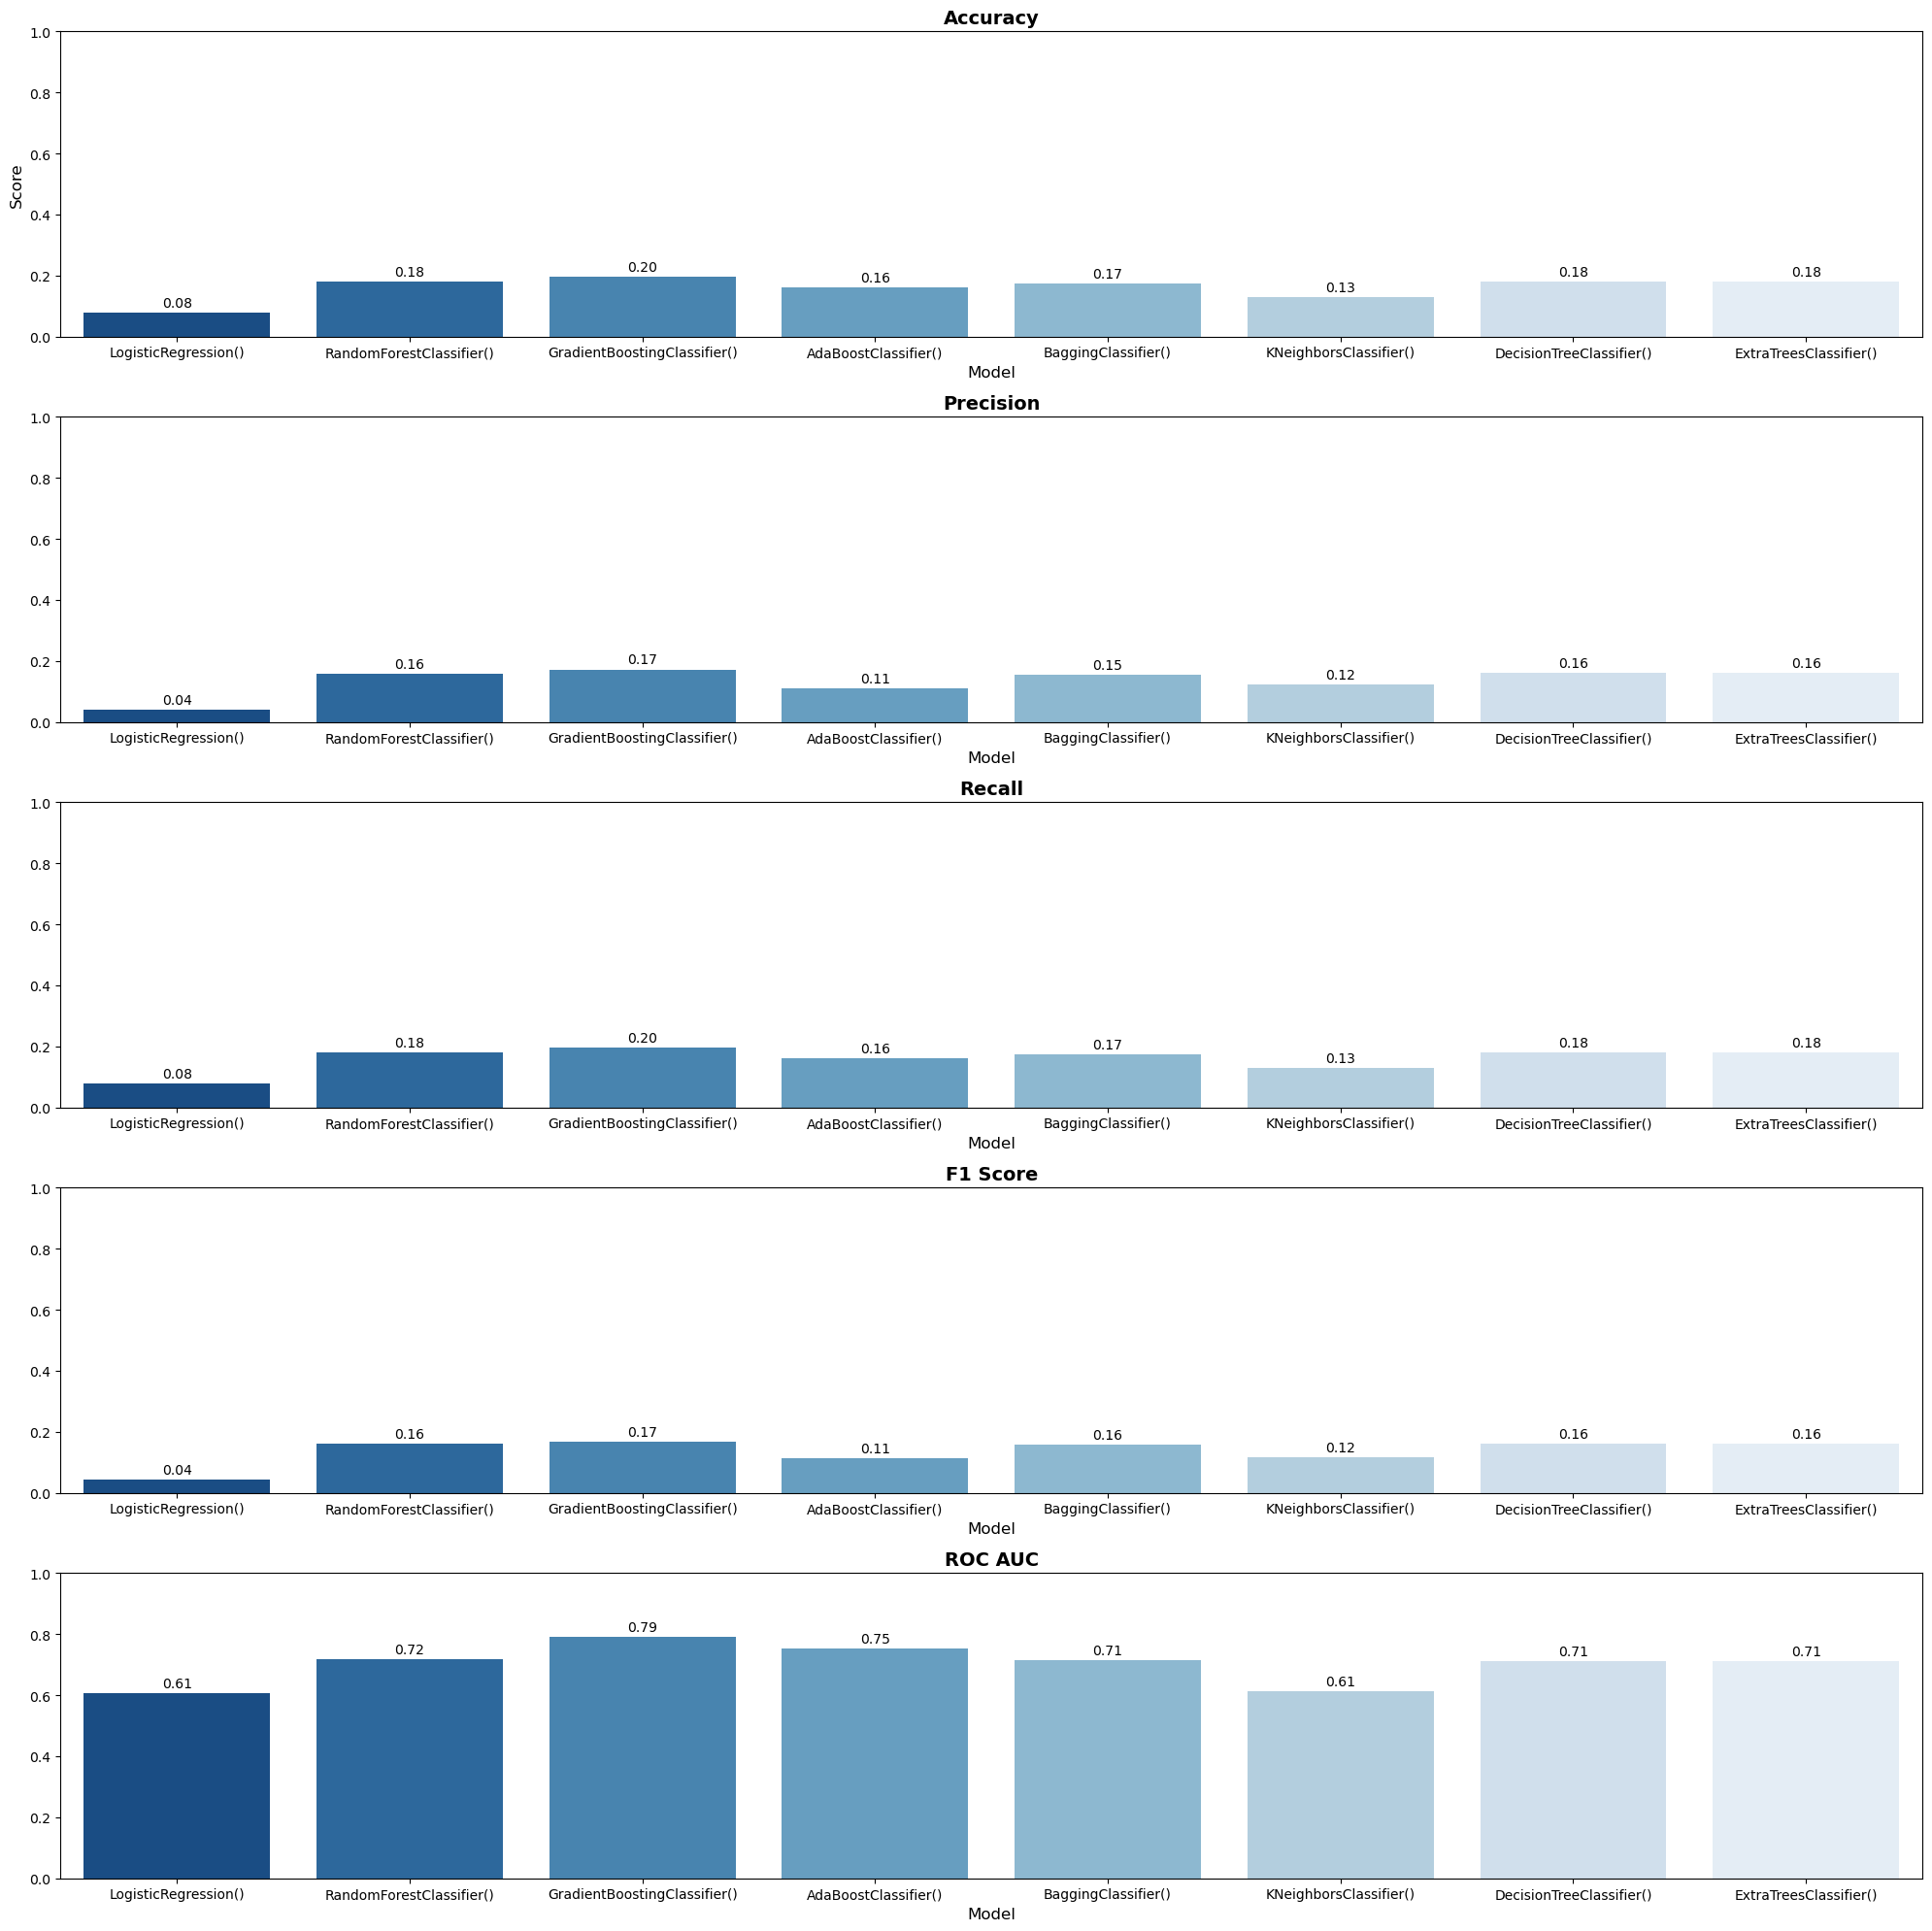

In [132]:
# Prepare data for plotting
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
metric_results = {metric: [] for metric in metrics}

# Collect data for each metric
for model, scores in model_metrics.items():
    for metric in metrics:
        metric_results[metric].append(scores.get(metric, 0))

# Create subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(20, 20), sharey=True)

# Plot each metric
for i, metric in enumerate(metrics):
    ax = axes[i]
    sns.barplot(x=list(model_metrics.keys()), y=metric_results[metric], palette="Blues_r", ax=ax)

    # Add labels to the bars
    for j, value in enumerate(metric_results[metric]):
        ax.text(j, value + 0.01, f'{value:.2f}', ha='center', va='bottom')

    # Set labels and title
    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylim([0,1])
    ax.set_title(metric, fontsize=14, weight='bold')
    ax.set_xticklabels(ax.get_xticklabels())

# Set common ylabel
axes[0].set_ylabel('Score', fontsize=12)

# Adjust layout
plt.tight_layout()

# Show plot
# plt.savefig('savefig/ClassificationModels.png')
plt.show()


_________

# Manual Grouping

In [259]:
genre_mapping = {
    # House Group
    'House': 'House',
    'Tech House': 'House',
    'Deep House': 'House',
    'Progressive House': 'House',
    'Funky House': 'House',
    'Jackin House': 'House',
    'Afro House': 'House',
    'Bass House': 'House',

    # Techno Group
    'Techno (Peak Time / Driving)': 'Techno',
    'Techno (Raw / Deep / Hypnotic)': 'Techno',
    'Minimal / Deep Tech': 'Techno',
    'Melodic House & Techno': 'Techno',
    'Hard Techno': 'Techno',

    # Trance Group
    'Trance (Main Floor)': 'Trance',
    'Psy-Trance': 'Trance',
    'Trance (Raw / Deep / Hypnotic)': 'Trance',

    # Bass Music Group
    'Drum & Bass': 'Bass Music',
    'Dubstep': 'Bass Music',
    '140 / Deep Dubstep / Grime': 'Bass Music',
    'Trap / Wave': 'Bass Music',
    'Breaks / Breakbeat / UK Bass': 'Bass Music',
    'Bass / Club': 'Bass Music',
    'UK Garage / Bassline': 'Bass Music',

    # Hard Dance & Hardcore Group
    'Hard Dance / Hardcore': 'Hard Dance & Hardcore',

    # Dance/Pop Group
    'Mainstage': 'Dance/Pop',
    'Dance / Electro Pop': 'Dance/Pop',
    'Nu Disco / Disco': 'Dance/Pop',

    # Downtempo & World Group
    'Organic House / Downtempo': 'Downtempo & World',
    'Amapiano': 'Downtempo & World',

    # Experimental & Indie Group
    'Electronica': 'Experimental & Indie',
    'Indie Dance': 'Experimental & Indie',
    'Electro (Classic / Detroit / Modern)': 'Experimental & Indie'
}


In [260]:
# Assuming your DataFrame is df and it has a column 'genre_name'
bp_genre['broad_genre'] = bp_genre['genre_name'].map(genre_mapping)

# Check the result
print(bp_genre[['genre_name', 'broad_genre']])

                              genre_name            broad_genre
0                  Hard Dance / Hardcore  Hard Dance & Hardcore
1                       Nu Disco / Disco              Dance/Pop
2                             Deep House                  House
3                            Bass / Club             Bass Music
4   Electro (Classic / Detroit / Modern)   Experimental & Indie
5                            Hard Techno                 Techno
6                                Dubstep             Bass Music
7             140 / Deep Dubstep / Grime             Bass Music
8                            Funky House                  House
9                      Progressive House                  House
10             Organic House / Downtempo      Downtempo & World
11                           Indie Dance   Experimental & Indie
12                            Afro House                  House
13                   Minimal / Deep Tech                 Techno
14                             Mainstage

In [261]:
# Assuming bp_media contains the genre_id and you want to replace it with genre_name

# Merge bp_media with bp_genre on 'genre_id'
bp_track = pd.merge(bp_track, bp_genre[['genre_id', 'broad_genre']], on='genre_id', how='left')

# Optionally, drop 'genre_id' if you no longer need it
bp_track.drop('genre_id', axis=1, inplace=True)

In [262]:
bp_track.isnull().sum()

bpm            0
key_id         0
broad_genre    0
dtype: int64

In [137]:
# Define your desired sample size for each class
sample_size = 5000  # Adjust this to your desired sample size

# Get the minimum count of samples available across all genres
min_count = bp_track['broad_genre'].value_counts().min()

# Ensure the sample size does not exceed the minimum class size
sample_size_per_class = min(sample_size, min_count)

# Sample from each genre
bp_sample = bp_track.groupby('broad_genre').apply(lambda x: x.sample(sample_size_per_class)).reset_index(drop=True)

C:\Users\Shank\AppData\Local\Temp\ipykernel_20448\990210175.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bp_sample = bp_track.groupby('broad_genre').apply(lambda x: x.sample(sample_size_per_class)).reset_index(drop=True)


In [138]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
le = LabelEncoder()

# Fit and transform the broad_genre column
bp_sample['broad_genre_encoded'] = le.fit_transform(bp_sample['broad_genre'])

# Check the result
bp_sample.head()

,bpm,key_id,broad_genre,broad_genre_encoded
0,142,11,Bass Music,0
1,145,9,Bass Music,0
2,120,16,Bass Music,0
3,87,19,Bass Music,0
4,100,9,Bass Music,0


In [139]:
features = bp_sample.drop(columns=['broad_genre', 'broad_genre_encoded'])

In [140]:
X = features
y = bp_sample['broad_genre_encoded']

In [141]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42)

In [142]:
model_metrics = train_and_evaluate_model(models=models)

c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the defaul

C:\Users\Shank\AppData\Local\Temp\ipykernel_20448\391156369.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(model_metrics.keys()), y=metric_results[metric], palette="Blues_r", ax=ax)
C:\Users\Shank\AppData\Local\Temp\ipykernel_20448\391156369.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels())
C:\Users\Shank\AppData\Local\Temp\ipykernel_20448\391156369.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(model_metrics.keys()), y=metric_results[metric], palette="Blues_r", ax=ax)
C:\Users\Shank\AppData\Local\Temp\ipykernel_20448\391156369.py:26: Use

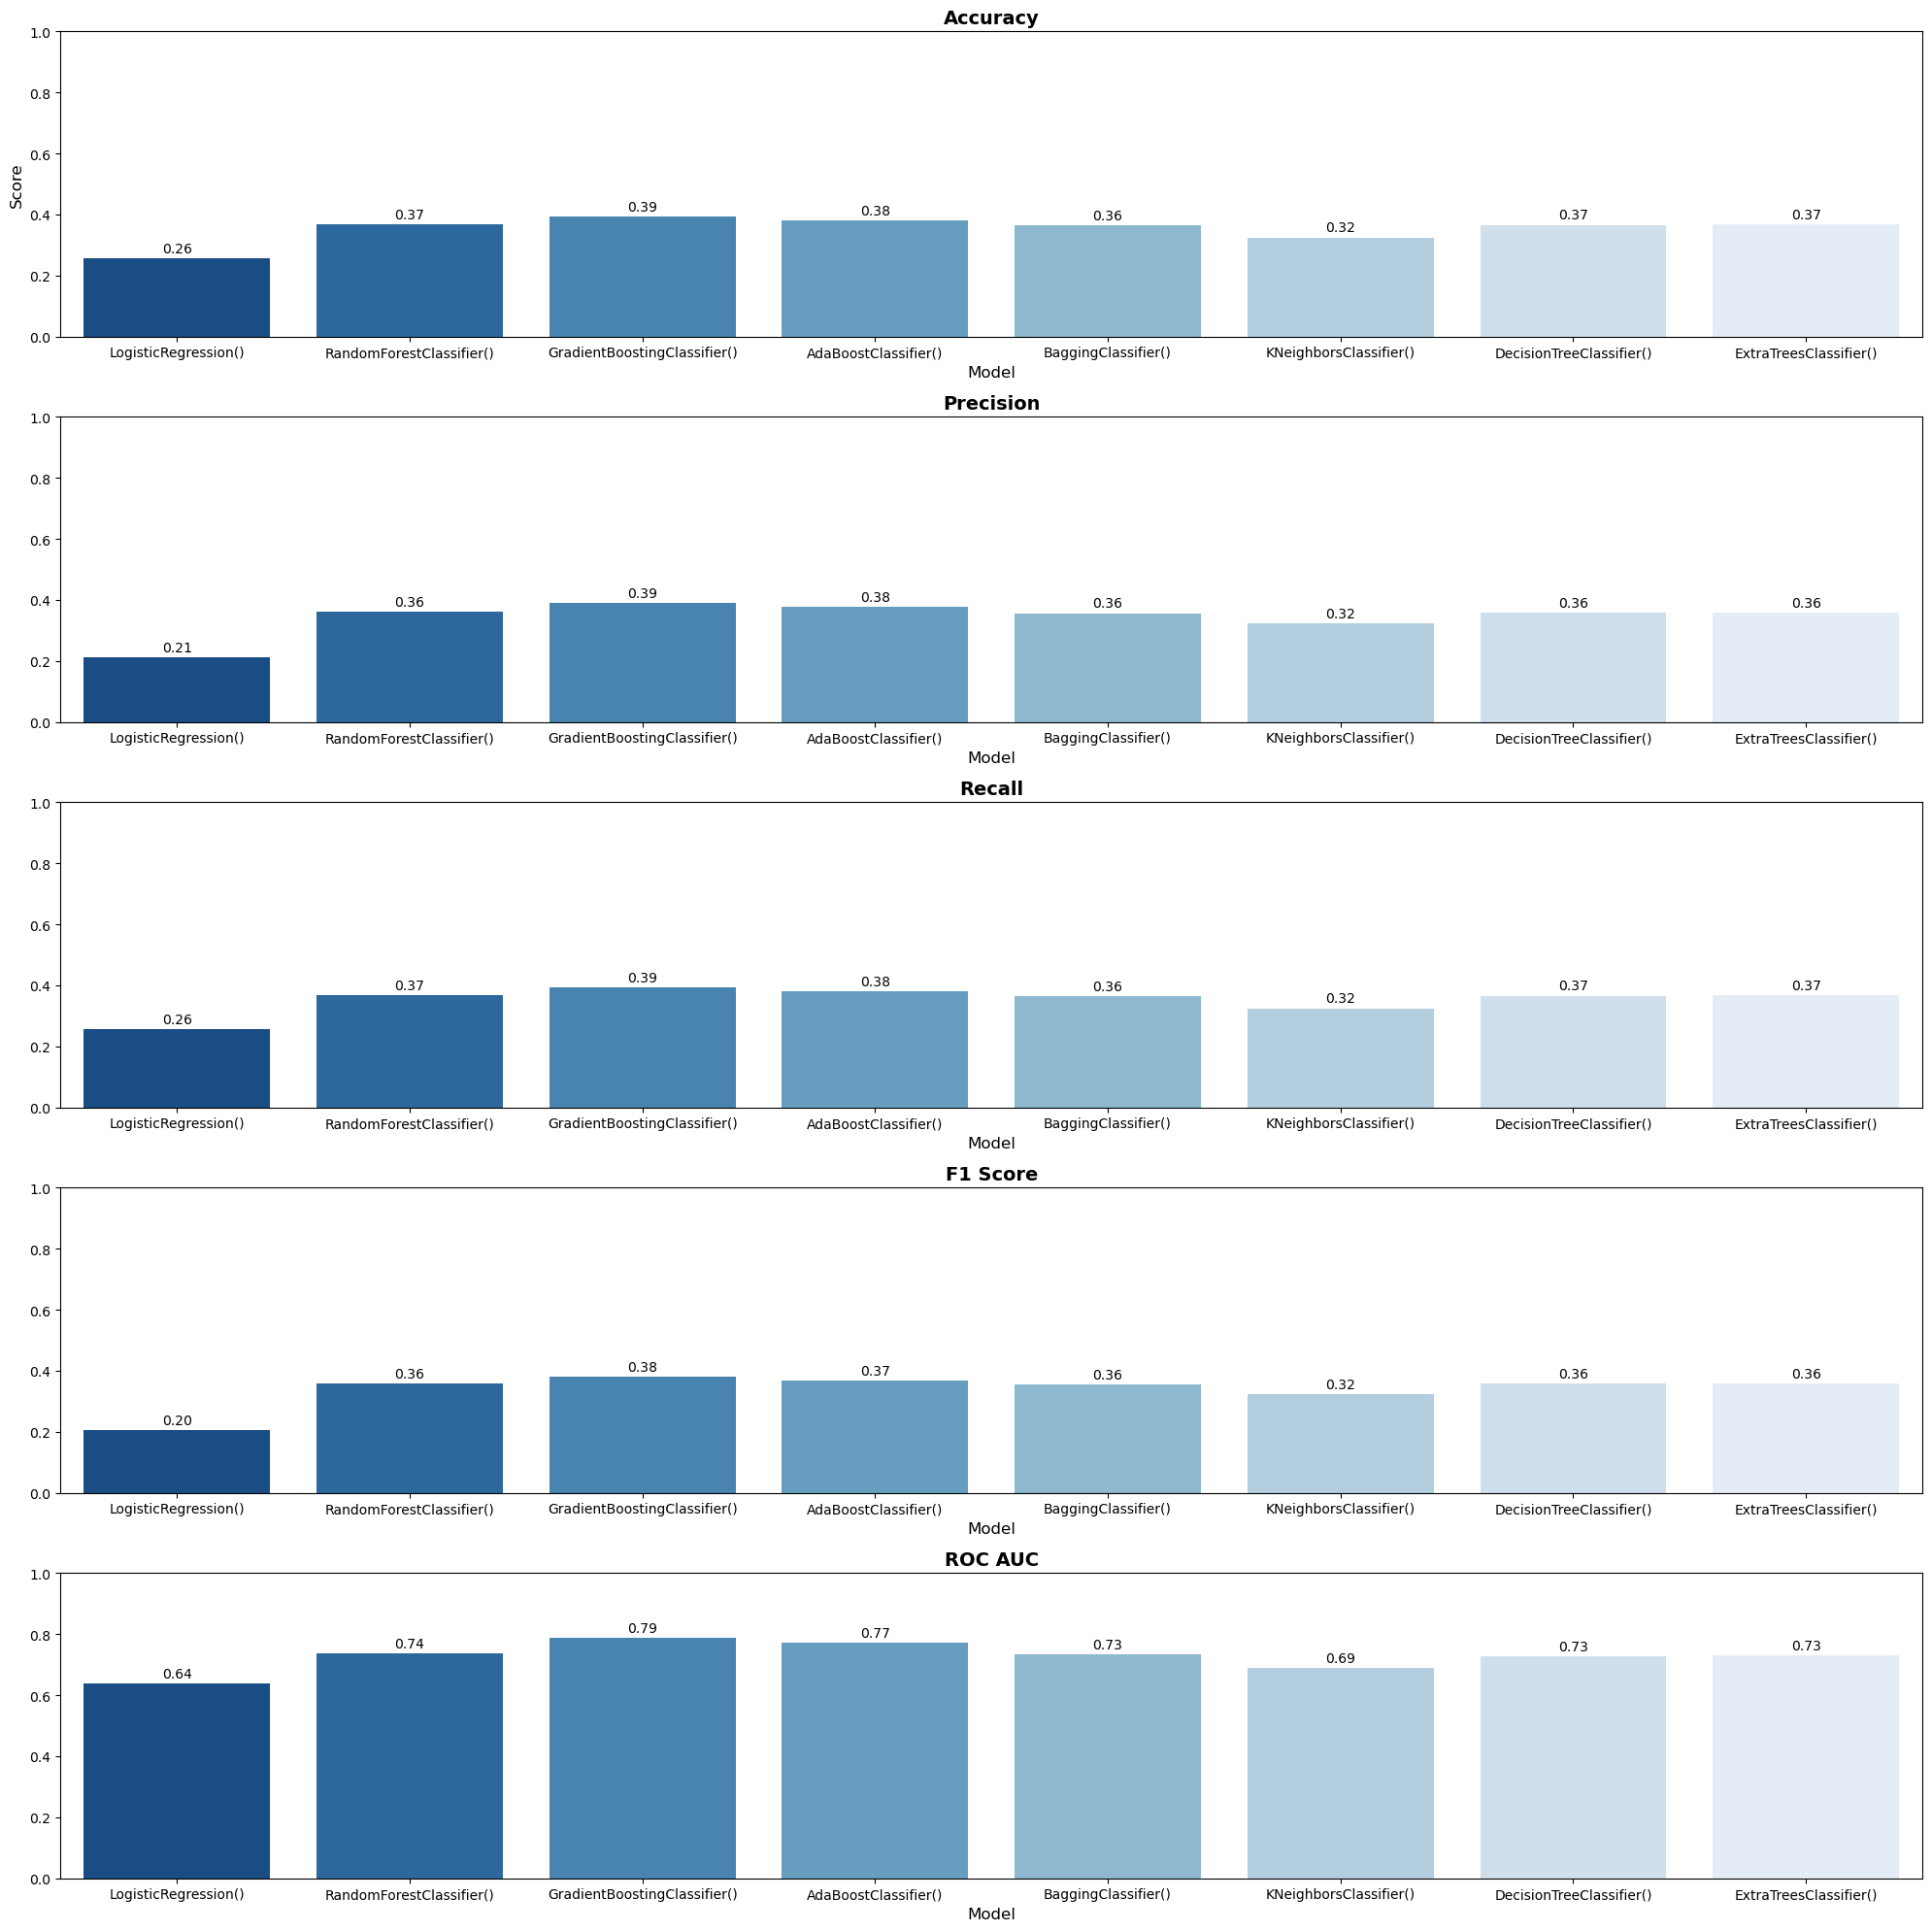

In [143]:
# Prepare data for plotting
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
metric_results = {metric: [] for metric in metrics}

# Collect data for each metric
for model, scores in model_metrics.items():
    for metric in metrics:
        metric_results[metric].append(scores.get(metric, 0))

# Create subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(20, 20), sharey=True)

# Plot each metric
for i, metric in enumerate(metrics):
    ax = axes[i]
    sns.barplot(x=list(model_metrics.keys()), y=metric_results[metric], palette="Blues_r", ax=ax)

    # Add labels to the bars
    for j, value in enumerate(metric_results[metric]):
        ax.text(j, value + 0.01, f'{value:.2f}', ha='center', va='bottom')

    # Set labels and title
    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylim([0,1])
    ax.set_title(metric, fontsize=14, weight='bold')
    ax.set_xticklabels(ax.get_xticklabels())

# Set common ylabel
axes[0].set_ylabel('Score', fontsize=12)

# Adjust layout
plt.tight_layout()

# Show plot
# plt.savefig('savefig/ClassificationModels.png')
plt.show()


_________

In [144]:
bp_track.head()

,bpm,key_id,broad_genre
0,130,20,Trance
1,124,4,Trance
2,124,6,Trance
3,93,10,Trance
4,125,2,Trance


In [200]:
sampled_data = bp_track.sample(n=5000, random_state=42)

In [201]:
bp_clustering = sampled_data.drop(columns='broad_genre', axis=1)

In [202]:
scaler = StandardScaler()

bp_clustering = scaler.fit_transform(bp_clustering)

_________

# KMeans Clustering

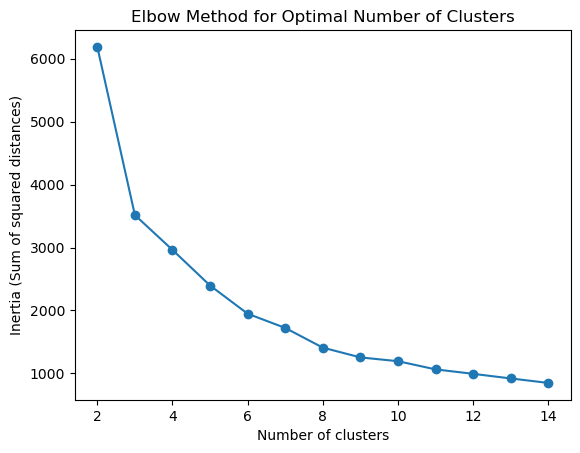

In [148]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Step 1: Apply KMeans for a range of cluster numbers
inertia = []
cluster_range = range(2, 15)  # Try different numbers of clusters, from 2 to 15

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(bp_clustering)
    inertia.append(kmeans.inertia_)

# Step 2: Plot the Elbow Curve
plt.plot(cluster_range, inertia, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia (Sum of squared distances)')
plt.show()

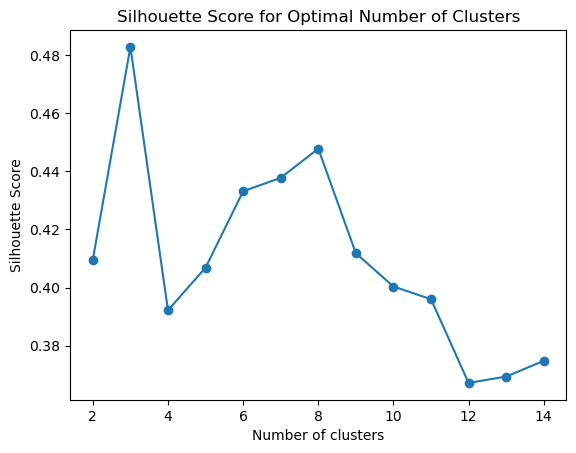

In [149]:
from sklearn.metrics import silhouette_score

# Step 1: Apply KMeans and compute Silhouette Scores for a range of cluster numbers
silhouette_scores = []
cluster_range = range(2, 15)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(bp_clustering)
    silhouette_avg = silhouette_score(bp_clustering, clusters)
    silhouette_scores.append(silhouette_avg)

# Step 2: Plot Silhouette Scores
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [150]:
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(bp_clustering)

In [151]:
sil_score = silhouette_score(bp_clustering, clusters)
print(f'Silhouette Score: {sil_score}')

Silhouette Score: 0.4477353470392841


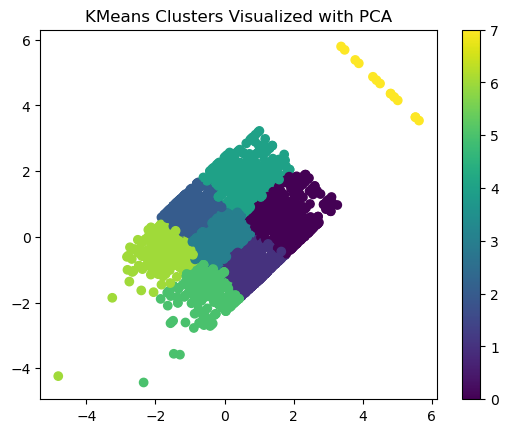

In [152]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce the dimensions of the data to 2D for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(bp_clustering)

# Plot the clusters in 2D space
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap='viridis')
plt.colorbar()
plt.title('KMeans Clusters Visualized with PCA')
plt.show()

_________

# DBSCAN Clustering

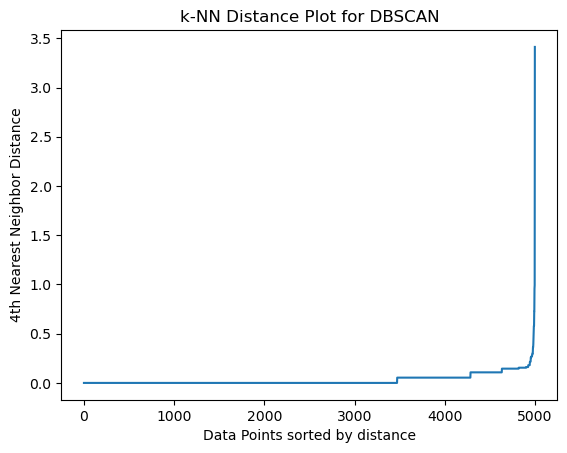

In [153]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# Find the k-nearest neighbors for each point (using k=4, as DBSCAN requires)
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(bp_clustering)
distances, indices = neighbors_fit.kneighbors(bp_clustering)

# Sort the distances to plot them
distances = np.sort(distances[:, 3], axis=0)  # Use the 4th nearest neighbor distance (for 4 neighbors)
plt.plot(distances)
plt.title('k-NN Distance Plot for DBSCAN')
plt.xlabel('Data Points sorted by distance')
plt.ylabel('4th Nearest Neighbor Distance')
plt.show()

In [154]:
from sklearn.cluster import DBSCAN

# Assuming you've chosen an appropriate value for `eps`
dbscan = DBSCAN(eps=0.2, min_samples=5)  # Tune min_samples based on your data
dbscan_clusters = dbscan.fit_predict(bp_clustering)

# Check how many clusters and how many outliers (noise points)
n_clusters = len(set(dbscan_clusters)) - (1 if -1 in dbscan_clusters else 0)
n_noise = list(dbscan_clusters).count(-1)
print(f'Estimated number of clusters: {n_clusters}')
print(f'Estimated number of noise points: {n_noise}')

Estimated number of clusters: 5
Estimated number of noise points: 46


In [155]:
# Filter out noise points for silhouette score (-1 represents noise)
if n_clusters > 1:
    valid_clusters = dbscan_clusters[dbscan_clusters != -1]
    valid_features = bp_clustering[dbscan_clusters != -1]

    sil_score = silhouette_score(valid_features, valid_clusters)
    print(f'Silhouette Score for DBSCAN: {sil_score}')
else:
    print("Not enough clusters for Silhouette Score")

Silhouette Score for DBSCAN: 0.1512372175477581


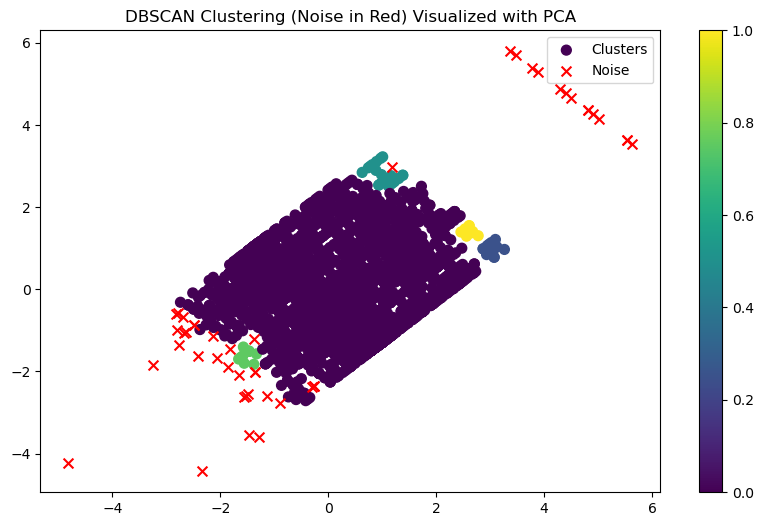

In [156]:
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# Assuming features_list_scaled contains your scaled feature data
# Reduce dimensionality to 2D for visualization
pca = PCA(n_components=2)
features_pca = pca.fit_transform(bp_clustering)

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.2, min_samples=5)  # Adjust 'eps' and 'min_samples' as needed
dbscan_clusters = dbscan.fit_predict(bp_clustering)

# Separate the noise (cluster -1) from the other clusters
core_samples_mask = dbscan_clusters != -1
noise_samples_mask = dbscan_clusters == -1

# Plot core clusters
plt.figure(figsize=(10, 6))
plt.scatter(features_pca[core_samples_mask, 0], features_pca[core_samples_mask, 1], 
            c=dbscan_clusters[core_samples_mask], cmap='viridis', s=50, label='Clusters')

# Plot noise samples
plt.scatter(features_pca[noise_samples_mask, 0], features_pca[noise_samples_mask, 1], 
            c='red', s=50, label='Noise', marker='x')

plt.colorbar()
plt.legend()
plt.title('DBSCAN Clustering (Noise in Red) Visualized with PCA')
plt.show()


_______

# Agglomerative Clustering

In [157]:
from sklearn.cluster import AgglomerativeClustering

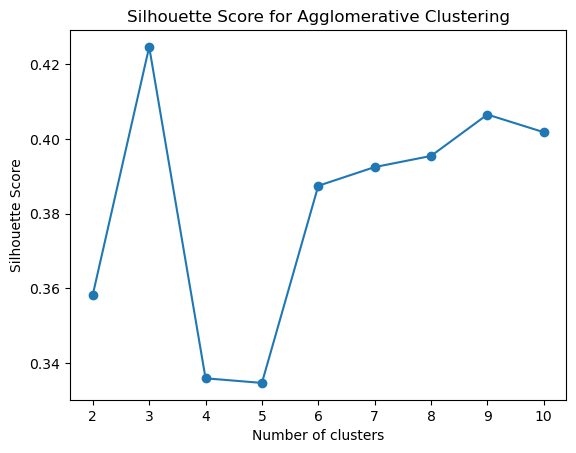

In [158]:
# List to store silhouette scores for different number of clusters
sil_scores = []

# Range of cluster numbers to test
cluster_range = range(2, 11)

for n_clusters in cluster_range:
    agglo = AgglomerativeClustering(n_clusters=n_clusters)
    agglo_clusters = agglo.fit_predict(bp_clustering)
    
    # Calculate the silhouette score
    sil_score = silhouette_score(bp_clustering, agglo_clusters)
    sil_scores.append(sil_score)

# Plot the silhouette scores for different cluster numbers
plt.plot(cluster_range, sil_scores, marker='o')
plt.title('Silhouette Score for Agglomerative Clustering')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

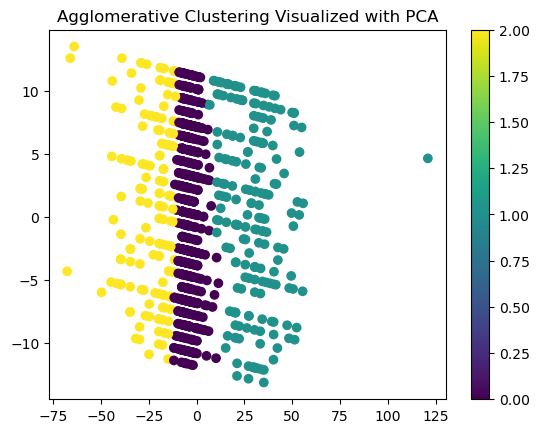

In [181]:
# Apply PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
features_pca = pca.fit_transform(bp_clustering)

# Apply KMeans on the original feature list
agglo = AgglomerativeClustering(n_clusters=3)
clusters = agglo.fit_predict(bp_clustering)

# Now visualize in 2D after PCA
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=clusters, cmap='viridis')
plt.colorbar()
plt.title('Agglomerative Clustering Visualized with PCA')
plt.show()

________

# GMM Clustering

In [160]:
from sklearn.mixture import GaussianMixture

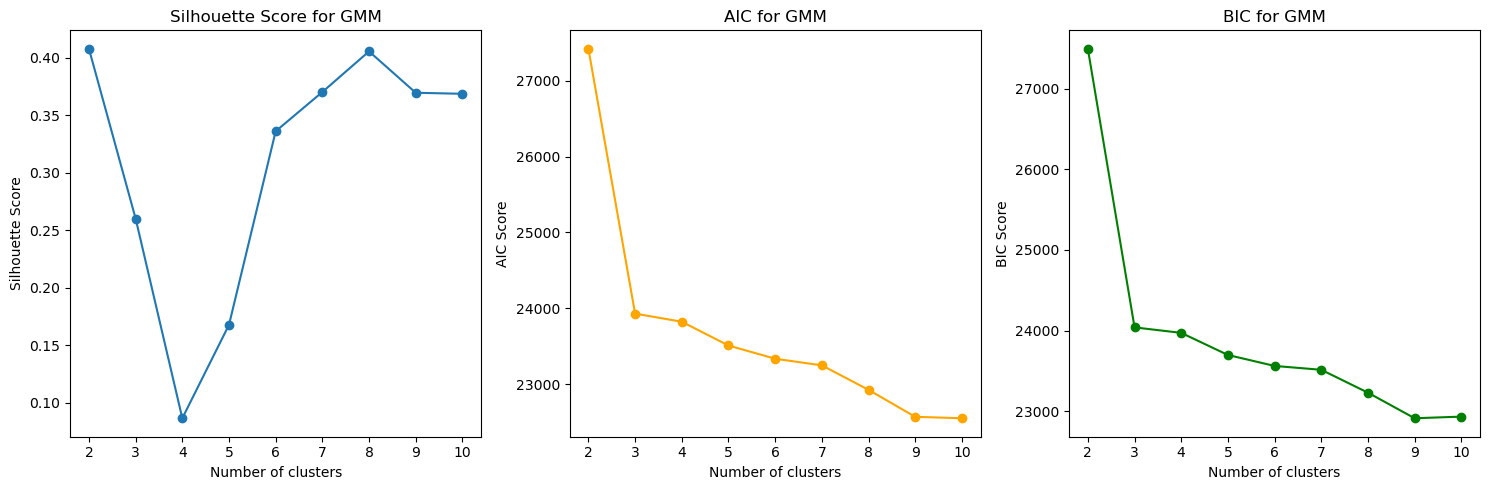

In [161]:
# Lists to store scores for different numbers of clusters
sil_scores = []
aic_scores = []
bic_scores = []

# Range of cluster numbers to test
cluster_range = range(2, 11)  # Try different numbers of clusters

for n_clusters in cluster_range:
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    
    # Fit the GMM model
    gmm_clusters = gmm.fit_predict(bp_clustering)
    
    # Calculate and append the silhouette score
    sil_score = silhouette_score(bp_clustering, gmm_clusters)
    sil_scores.append(sil_score)
    
    # Append AIC and BIC scores
    aic_scores.append(gmm.aic(bp_clustering))
    bic_scores.append(gmm.bic(bp_clustering))

# Plot the results
plt.figure(figsize=(15, 5))

# Plot Silhouette Scores
plt.subplot(1, 3, 1)
plt.plot(cluster_range, sil_scores, marker='o')
plt.title('Silhouette Score for GMM')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

# Plot AIC Scores
plt.subplot(1, 3, 2)
plt.plot(cluster_range, aic_scores, marker='o', label='AIC', color='orange')
plt.title('AIC for GMM')
plt.xlabel('Number of clusters')
plt.ylabel('AIC Score')

# Plot BIC Scores
plt.subplot(1, 3, 3)
plt.plot(cluster_range, bic_scores, marker='o', label='BIC', color='green')
plt.title('BIC for GMM')
plt.xlabel('Number of clusters')
plt.ylabel('BIC Score')

plt.tight_layout()
plt.show()

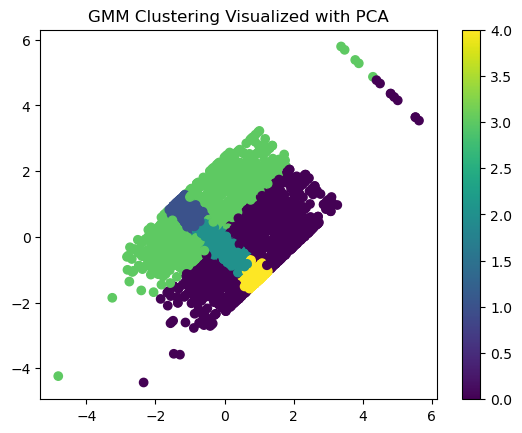

In [162]:
# Apply PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
features_pca = pca.fit_transform(bp_clustering)

# Apply KMeans on the original feature list
gmm = GaussianMixture(n_components=5)
clusters = gmm.fit_predict(bp_clustering)

# Now visualize in 2D after PCA
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=clusters, cmap='viridis')
plt.colorbar()
plt.title('GMM Clustering Visualized with PCA')
plt.show()

____________

# Spectral Clustering

c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\manifold\_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\manifold\_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\manifold\_spectral_embedding.py:275: UserWar

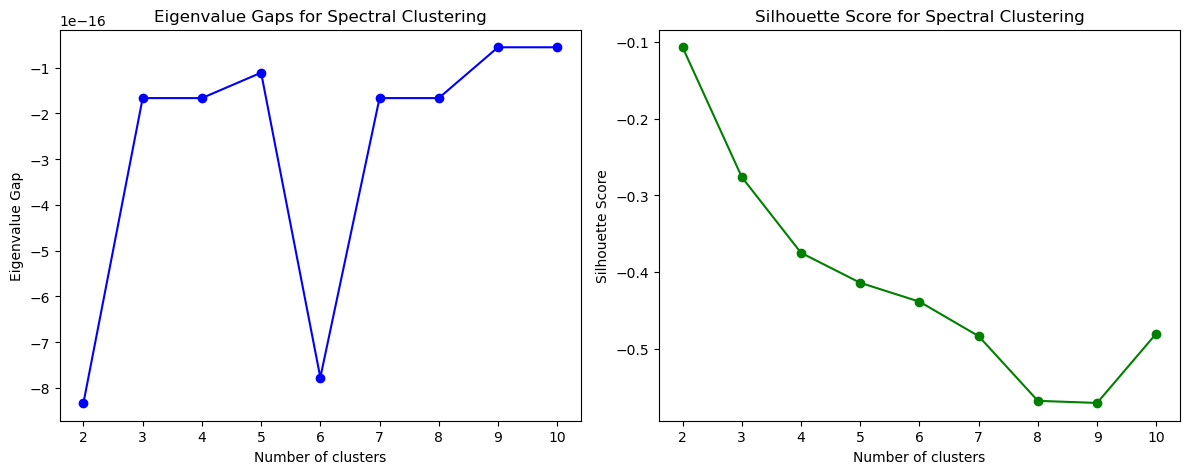

In [163]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.neighbors import kneighbors_graph
from sklearn.manifold import spectral_embedding

# Define a function to calculate eigenvalue gap
def calculate_eigenvalue_gaps(bp_clustering, cluster_range):
    eigenvalue_gaps = []
    
    for n_clusters in cluster_range:
        # Create the affinity matrix using k-nearest neighbors graph
        affinity_matrix = kneighbors_graph(bp_clustering, n_neighbors=10).toarray()
        
        # Compute the spectral embedding (eigenvalues of Laplacian matrix)
        embedding = spectral_embedding(affinity_matrix, n_components=n_clusters)
        eigenvalues = np.linalg.svd(embedding, compute_uv=False)  # Get singular values (eigenvalues)
        
        # Compute the eigenvalue gaps
        eigenvalue_gaps.append(np.diff(eigenvalues).max())  # Largest gap between consecutive eigenvalues
    
    return eigenvalue_gaps

# List to store silhouette scores for different number of clusters
sil_scores = []

# Range of cluster numbers to test
cluster_range = range(2, 11)

# Calculate the eigenvalue gaps
eigenvalue_gaps = calculate_eigenvalue_gaps(bp_clustering, cluster_range)

# Perform spectral clustering and calculate silhouette scores
for n_clusters in cluster_range:
    # Apply Spectral Clustering
    spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
    cluster_labels = spectral.fit_predict(bp_clustering)
    
    # Calculate silhouette score
    sil_score = silhouette_score(bp_clustering, cluster_labels)
    sil_scores.append(sil_score)

# Plot the eigenvalue gaps and silhouette scores side by side
plt.figure(figsize=(12, 5))

# Plot Eigenvalue Gaps
plt.subplot(1, 2, 1)
plt.plot(cluster_range, eigenvalue_gaps, marker='o', color='blue')
plt.title('Eigenvalue Gaps for Spectral Clustering')
plt.xlabel('Number of clusters')
plt.ylabel('Eigenvalue Gap')

# Plot Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(cluster_range, sil_scores, marker='o', color='green')
plt.title('Silhouette Score for Spectral Clustering')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()


In [164]:
# Apply Clustering on the original feature list
spectral = SpectralClustering(n_components=4)
clusters = spectral.fit_predict(bp_clustering)

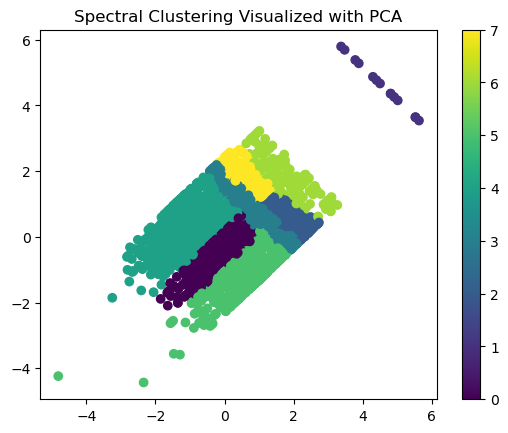

In [165]:
# Apply PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
features_pca = pca.fit_transform(bp_clustering)

# Now visualize in 2D after PCA
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=clusters, cmap='viridis')
plt.colorbar()
plt.title('Spectral Clustering Visualized with PCA')
plt.show()

______

# Mean Shift Clustering

In [166]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Estimate bandwidth for MeanShift algorithm (you can also manually set it)
bandwidth = estimate_bandwidth(bp_clustering, quantile=0.2, n_samples=500)

# Apply Mean Shift clustering
mean_shift = MeanShift(bandwidth=bandwidth, bin_seeding=True)
mean_shift_clusters = mean_shift.fit_predict(bp_clustering)

# Print the number of clusters found
n_clusters = len(np.unique(mean_shift_clusters))
print(f'Number of clusters found: {n_clusters}')

Number of clusters found: 8


In [167]:
sil_score = silhouette_score(bp_clustering, mean_shift_clusters)
print(f'Silhouette Score for Mean Shift: {sil_score}')

Silhouette Score for Mean Shift: 0.4736756972443318


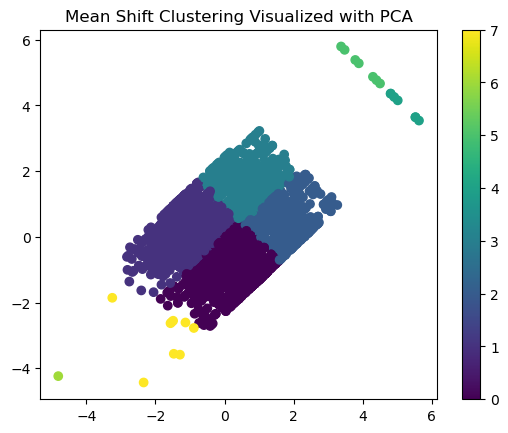

In [168]:
# Apply PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
features_pca = pca.fit_transform(bp_clustering)

# Now visualize in 2D after PCA
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=mean_shift_clusters, cmap='viridis')
plt.colorbar()
plt.title('Mean Shift Clustering Visualized with PCA')
plt.show()

____________

# MiniBatch KMeans Clustering

In [203]:
from sklearn.cluster import MiniBatchKMeans

c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\cluster\_kmeans.py:1972: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(
c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\cluster\_kmeans.py:1972: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(
c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\cluster\_kmeans.py:1972: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_T

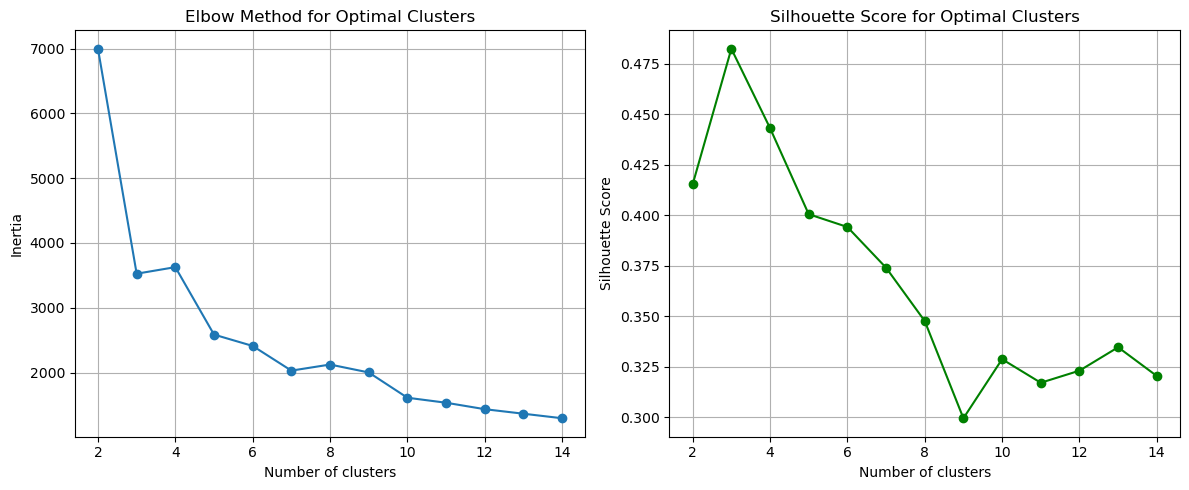

In [204]:
# Range of cluster numbers to test
cluster_range = range(2, 15)

# Lists to store inertia and silhouette scores
inertia_scores = []
sil_scores = []

# Iterate over the cluster range
for n_clusters in cluster_range:
    # Initialize MiniBatch KMeans
    mbkmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=10, random_state=42)
    
    # Fit the model
    mbkmeans.fit(bp_clustering)
    
    # Append the inertia (for the elbow method)
    inertia_scores.append(mbkmeans.inertia_)
    
    # Predict cluster labels and calculate the silhouette score
    cluster_labels = mbkmeans.predict(bp_clustering)
    sil_score = silhouette_score(bp_clustering, cluster_labels)
    sil_scores.append(sil_score)

# Plotting the Elbow Test and Silhouette Score Test side by side
plt.figure(figsize=(12, 5))

# Elbow Method (Inertia)
plt.subplot(1, 2, 1)
plt.plot(cluster_range, inertia_scores, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.grid(True)

# Silhouette Score Test
plt.subplot(1, 2, 2)
plt.plot(cluster_range, sil_scores, marker='o', color='green')
plt.title('Silhouette Score for Optimal Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)

plt.tight_layout()
plt.show()

c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\cluster\_kmeans.py:1972: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


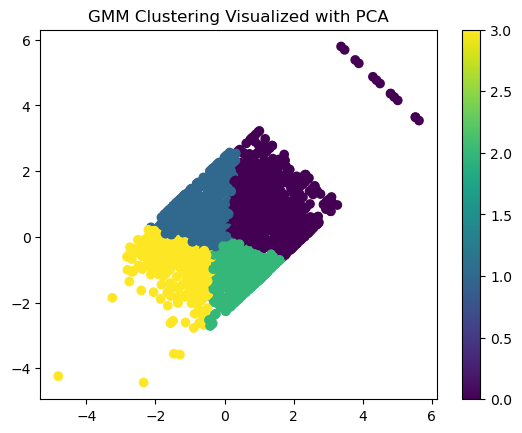

In [208]:
# Apply PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
features_pca = pca.fit_transform(bp_clustering)

# Apply KMeans on the original feature list
mbkmeans = MiniBatchKMeans(n_clusters=4,batch_size=10,random_state=42)
clusters = mbkmeans.fit_predict(bp_clustering)

# Now visualize in 2D after PCA
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=clusters, cmap='viridis')
plt.colorbar()
plt.title('GMM Clustering Visualized with PCA')
plt.show()

____

# Picking a Model

KMeans/MiniBatches KMeans

In [303]:
sampled_data = bp_track.sample(n=50000, random_state=42)
bp_clustering = sampled_data.drop(columns='broad_genre', axis=1)
scaler = StandardScaler()

bp_clustering = scaler.fit_transform(bp_clustering)

In [304]:
sil_scores = []

# Range of cluster numbers to test
cluster_range = range(4, 9)

for n_clusters in cluster_range:
    # Apply KMeans on the original feature list
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(bp_clustering)
    
    # Calculate the silhouette score
    sil_score = silhouette_score(bp_clustering, clusters)
    sil_scores.append(sil_score)

# Find the number of clusters with the highest silhouette score
peak_silo = cluster_range[sil_scores.index(max(sil_scores))]

print(f"The optimal number of clusters is: {peak_silo}")

The optimal number of clusters is: 8


In [305]:
bp = bp_track.dropna().drop(columns='broad_genre',axis=1)

In [306]:
bp = scaler.fit_transform(bp)

In [308]:
# Use the peak_silo number of clusters for final model
mbkmeans = MiniBatchKMeans(n_clusters=peak_silo, batch_size=5000, random_state=42,verbose=1) 
mbkmeans_clusters = mbkmeans.fit_predict(bp)

Init 1/1 with method k-means++
Inertia for init 1/1: 7110.567902661702
Minibatch step 1/213581: mean batch inertia: 0.4493946906449505
Minibatch step 2/213581: mean batch inertia: 0.4072545880996592, ewa inertia: 0.4072545880996592
Minibatch step 3/213581: mean batch inertia: 0.3628372001422164, ewa inertia: 0.4072129951943939
Minibatch step 4/213581: mean batch inertia: 0.37609184845772936, ewa inertia: 0.4071838530280602
Minibatch step 5/213581: mean batch inertia: 0.378680693895331, ewa inertia: 0.40715716237261906
Minibatch step 6/213581: mean batch inertia: 0.36661954162717336, ewa inertia: 0.4071192025218291
Minibatch step 7/213581: mean batch inertia: 0.3876406175331579, ewa inertia: 0.4071009625717242
Minibatch step 8/213581: mean batch inertia: 0.34554220943913294, ewa inertia: 0.4070433183133597
Minibatch step 9/213581: mean batch inertia: 0.35342843097048016, ewa inertia: 0.40699311277375894
Minibatch step 10/213581: mean batch inertia: 0.3187128437919044, ewa inertia: 0.406

In [310]:
bp = scaler.inverse_transform(bp)

In [312]:
clustered_data = pd.DataFrame(bp, columns=['BPM', 'Key'])
clustered_data['Cluster'] = mbkmeans_clusters

# Generate summary statistics for each cluster
summary = clustered_data.groupby('Cluster').agg(['mean', 'median', 'std'])
summary

BPM                          Key                 
               mean median        std       mean median       std
Cluster                                                          
0        124.923770  125.0   5.367779   3.650383    3.0  2.125869
1         93.535433   93.0   7.960917  18.256017   19.0  3.192156
2         61.170251   70.0  25.138773  14.242136   15.0  5.043077
3        124.895842  125.0   4.659857  19.707023   19.0  2.242730
4        147.527680  145.0  10.862713  18.277560   19.0  2.929306
5         90.578655   90.0   9.198681   5.835435    6.0  3.458753
6        125.059638  125.0   5.433876  11.653888   12.0  2.307267
7        149.050371  146.0  11.458105   6.811215    7.0  3.293036

In [313]:
from sklearn.metrics import classification_report, confusion_matrix

X = clustered_data[['BPM', 'Key']]
y = clustered_data['Cluster']

# Step 1: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)

In [314]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [315]:
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 1.0000

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   2170020
           1       1.00      1.00      1.00    715316
           2       1.00      1.00      1.00    223964
           3       1.00      1.00      1.00   2461563
           4       1.00      1.00      1.00    524911
           5       1.00      1.00      1.00    782963
           6       1.00      1.00      1.00   2256769
           7       1.00      1.00      1.00    475664

    accuracy                           1.00   9611170
   macro avg       1.00      1.00      1.00   9611170
weighted avg       1.00      1.00      1.00   9611170



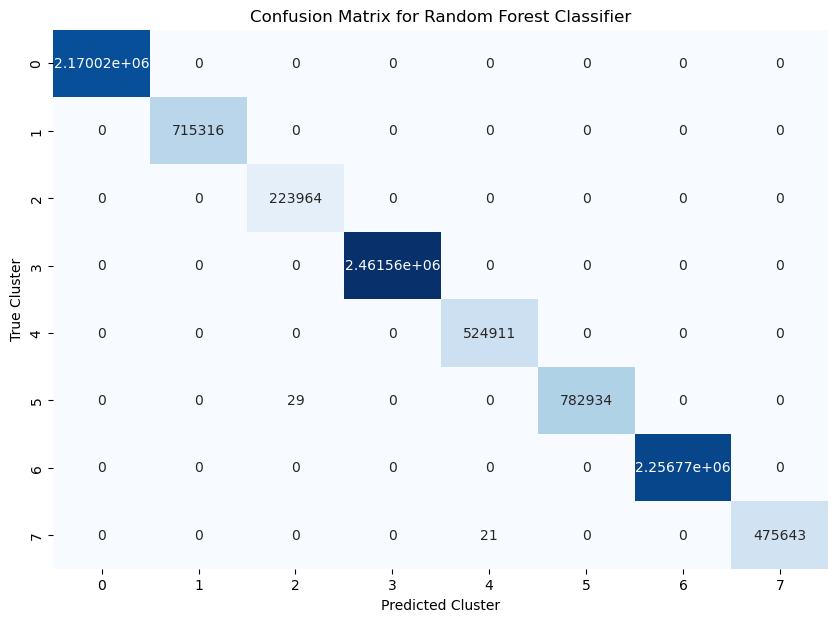

In [316]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False, 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))

# Add labels and title
plt.xlabel('Predicted Cluster')
plt.ylabel('True Cluster')
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()

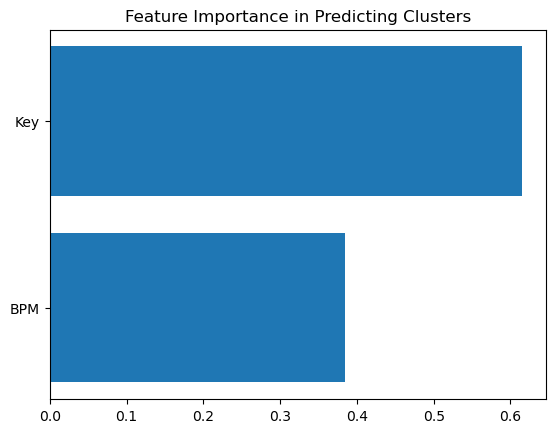

In [317]:
feature_importances = clf.feature_importances_
features = ['BPM', 'Key']

# Plot the feature importances
plt.barh(features, feature_importances)
plt.title('Feature Importance in Predicting Clusters')
plt.show()